## Project: **Advanced Lane Finding** 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Starter material can be found at [https://github.com/udacity/CarND-Advanced-Lane-Lines](https://github.com/udacity/CarND-Advanced-Lane-Lines).

### Import Packages

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import os

# inline plots
#%matplotlib inline 
%pylab inline

### Camera Calibration

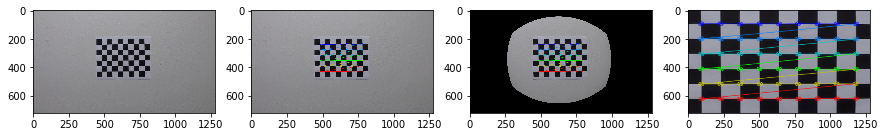

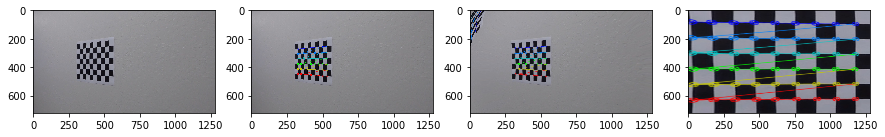

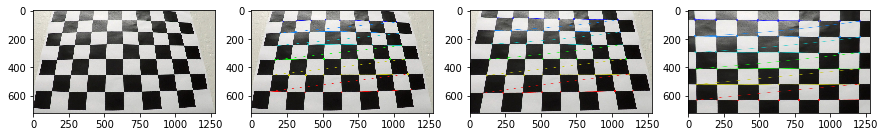

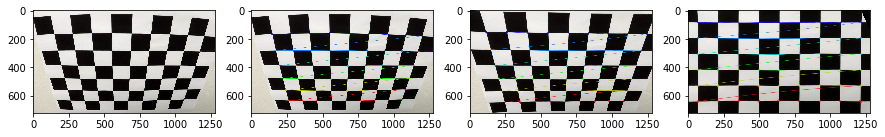

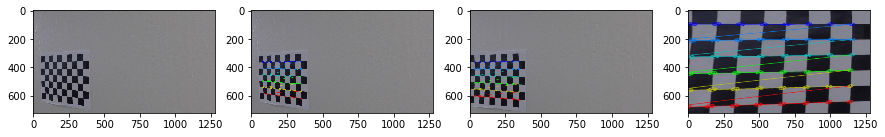

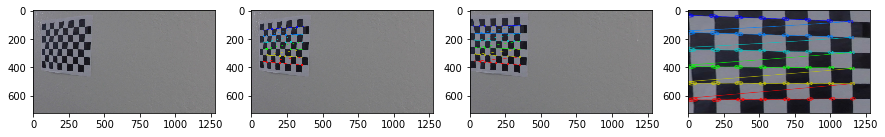

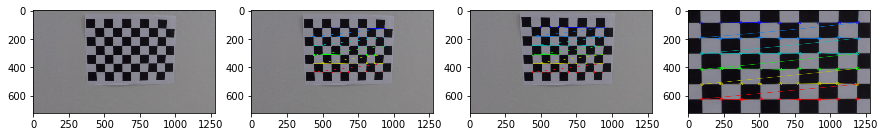

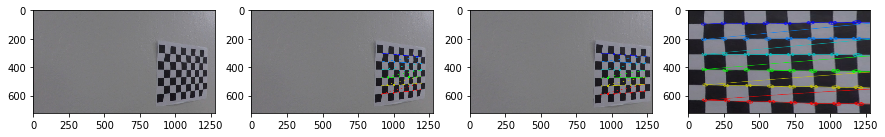

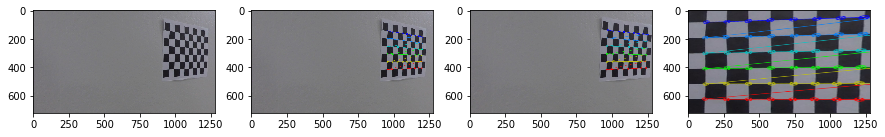

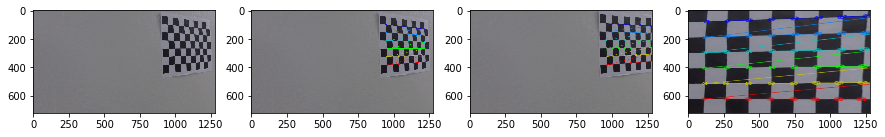

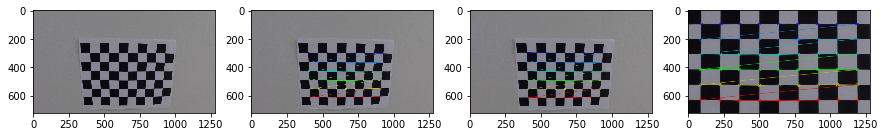

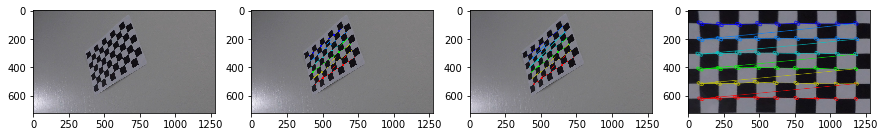

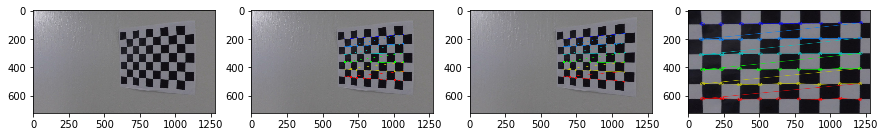

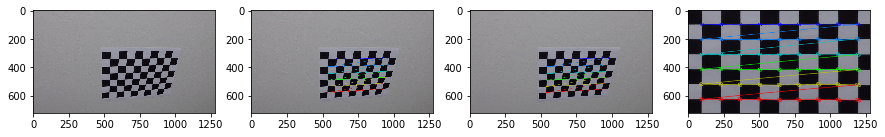

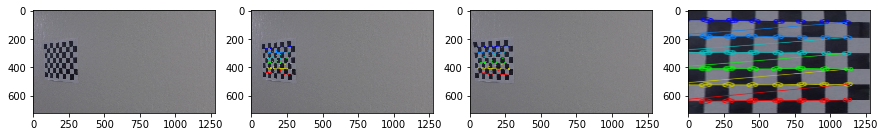

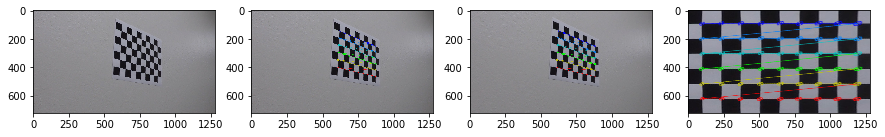

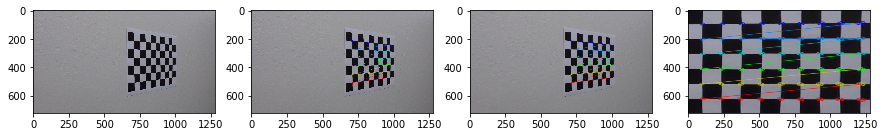

In [2]:
import glob

pylab.rcParams['figure.figsize'] = (15,15)

# Read in calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images
objpoints = []  # 3D points in real world space
imgpoints = [] # 2D points in image plane

nx = 9
ny = 6

# Prepare object points
objp =  np.zeros([nx*ny, 3], np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coords

for fn in images:

    # Read in images
    img = mpimg.imread(fn)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
    # If corners found, add to object points and image points
    if ret == True:
        
        # Save corners and object points
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Print original image for reference
        f, axarr = plt.subplots(1, 4)
        axarr[0].imshow(img)
        
        # draw and display the corners
        axarr[1].imshow(cv2.drawChessboardCorners(img, (nx,ny), corners, ret))
        
        # apply undistort        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        axarr[2].imshow(undist)
        
        # define 4 source points
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

        # define 4 destintaion points
        offset = 100
        img_size = (undist.shape[1], undist.shape[0])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
        [img_size[0]-offset, img_size[1]-offset], 
        [offset, img_size[1]-offset]])
        
        # obtain the transform matrix and inverse transform
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        
        # warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        axarr[3].imshow(warped)


### Pipeline (test images)

Radius of curvature:  1327.9837834 m,  826.371393347 m     Center offset:  0.288071428571 m
Radius of curvature:  305.273954401 m,  1450.0202036 m     Center offset:  0.0211428571429 m
Radius of curvature:  1089.42233511 m,  972.092377304 m     Center offset:  0.256357142857 m
Radius of curvature:  987.590038431 m,  1400.22367577 m     Center offset:  0.261642857143 m
Radius of curvature:  870.205534023 m,  870.332090144 m     Center offset:  0.103071428571 m
Radius of curvature:  723.171170273 m,  1677.34668642 m     Center offset:  0.206142857143 m
Radius of curvature:  2512.38040692 m,  491140.75833 m     Center offset:  0.0132142857143 m
Radius of curvature:  866.063270442 m,  20672.9326463 m     Center offset:  0.00264285714286 m


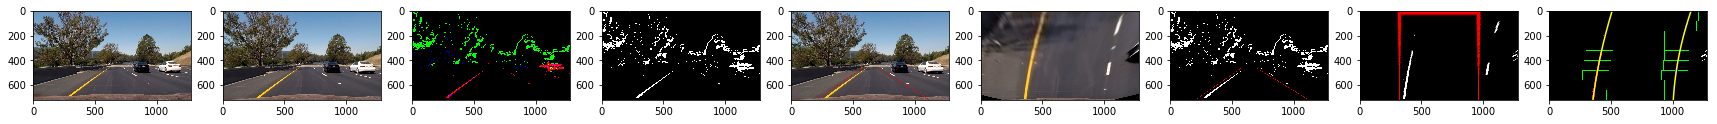

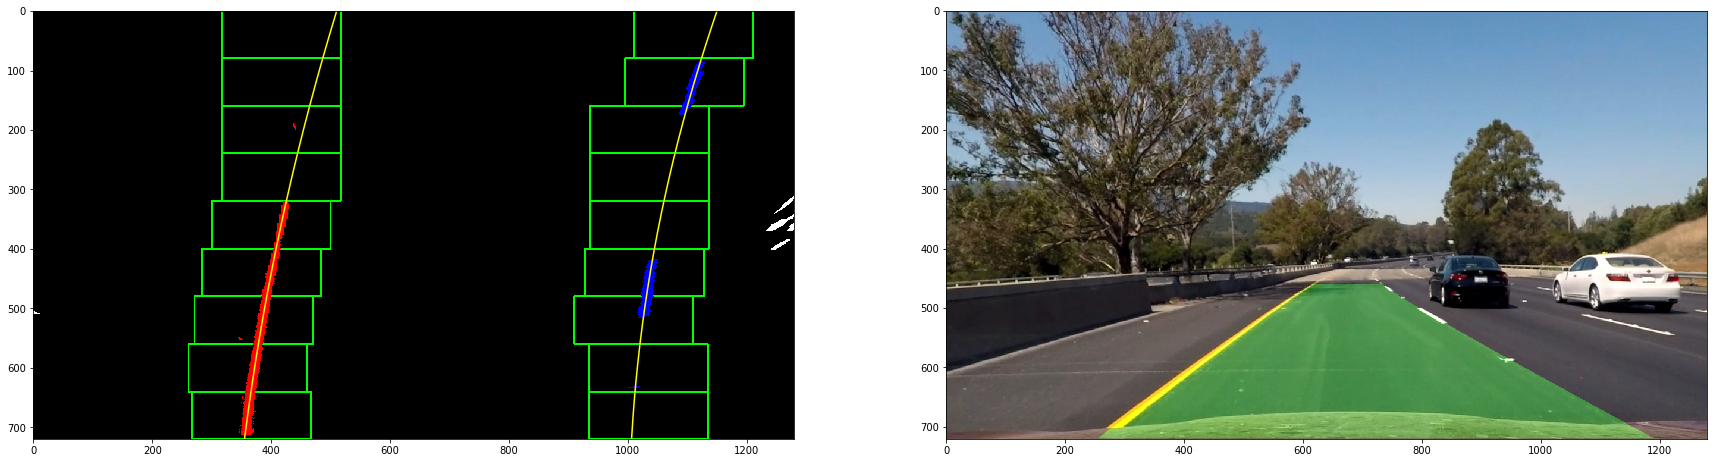

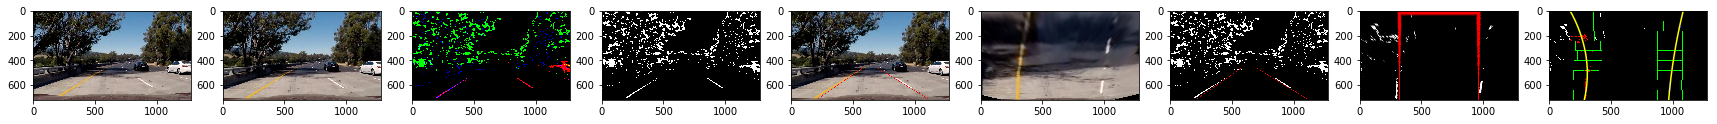

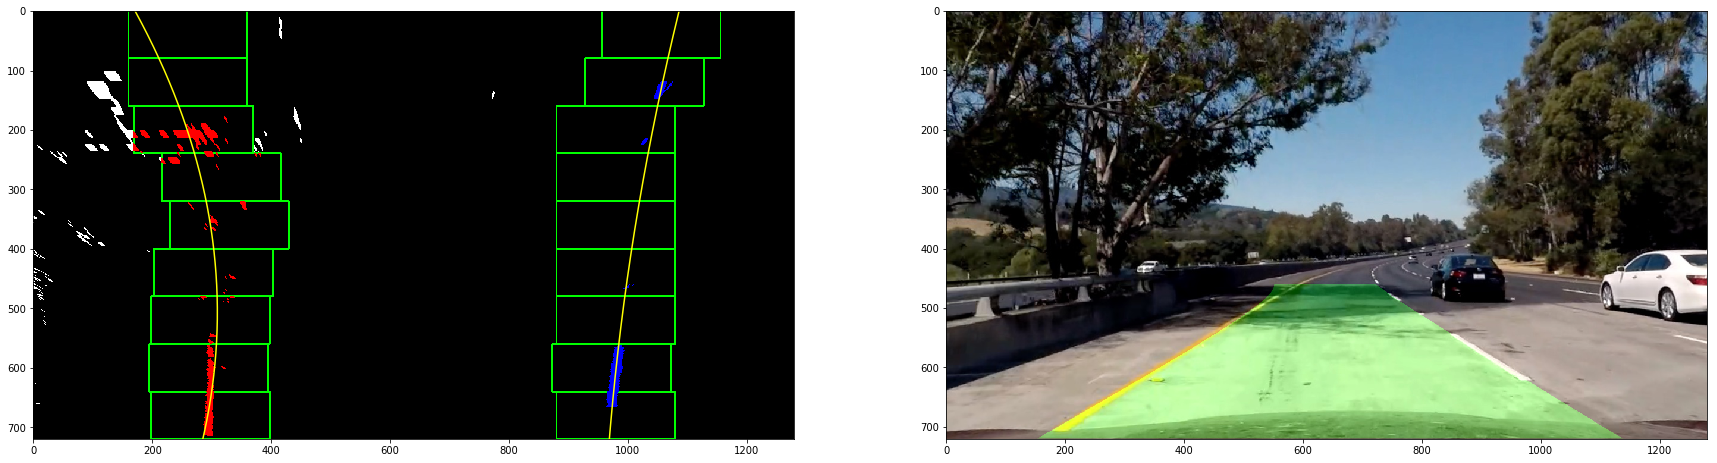

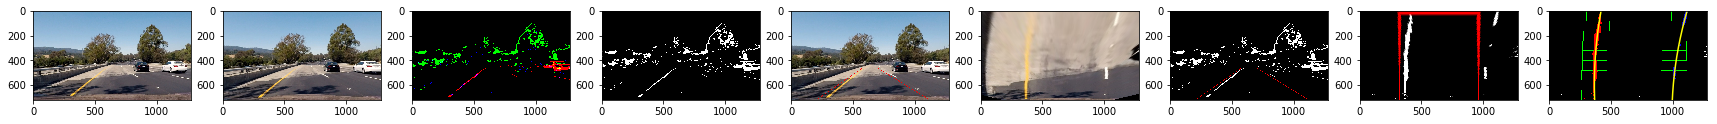

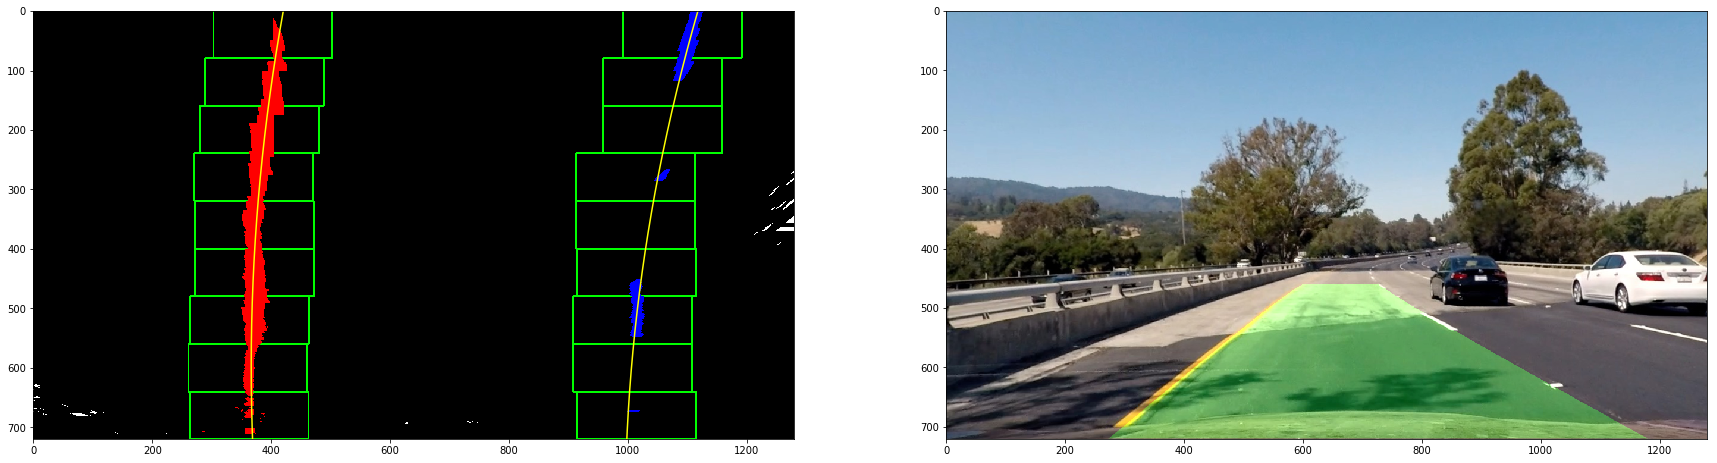

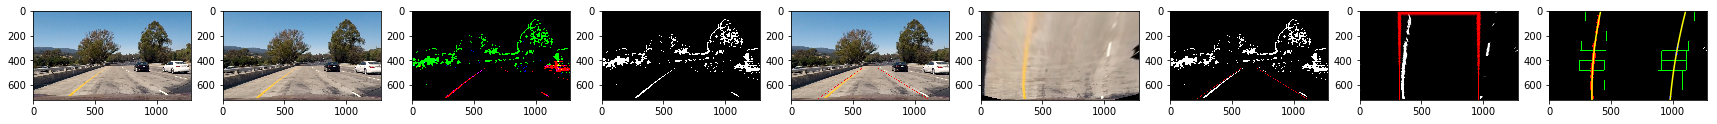

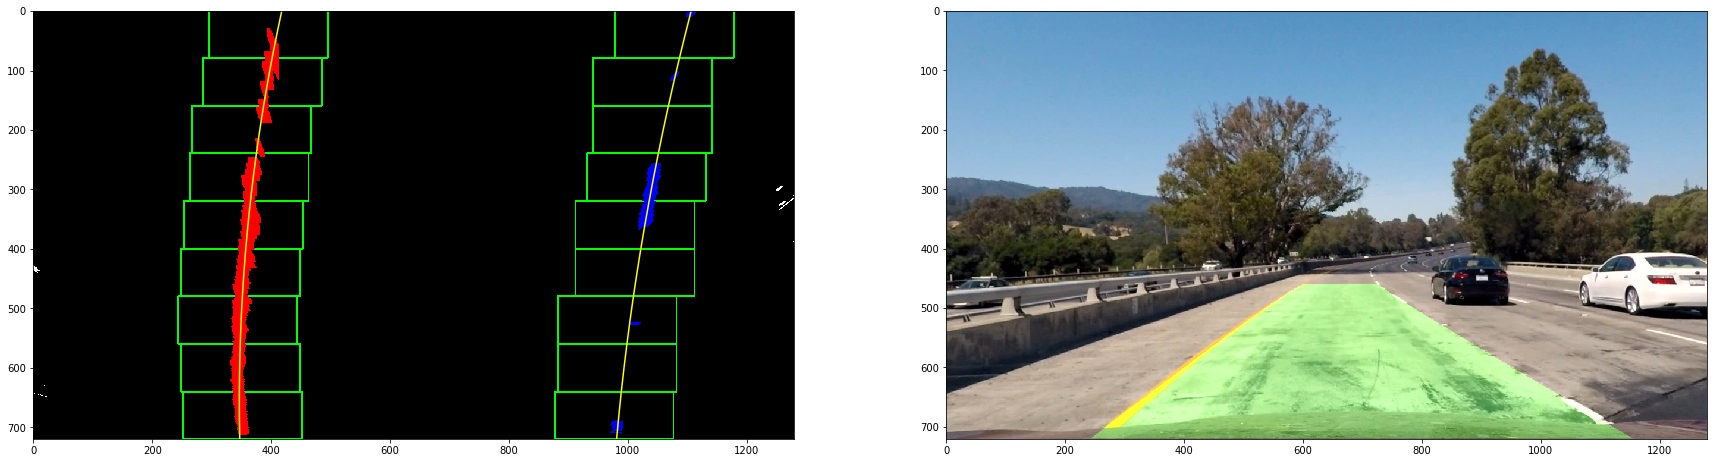

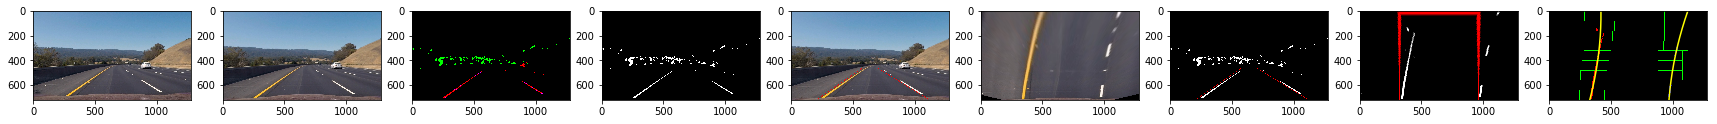

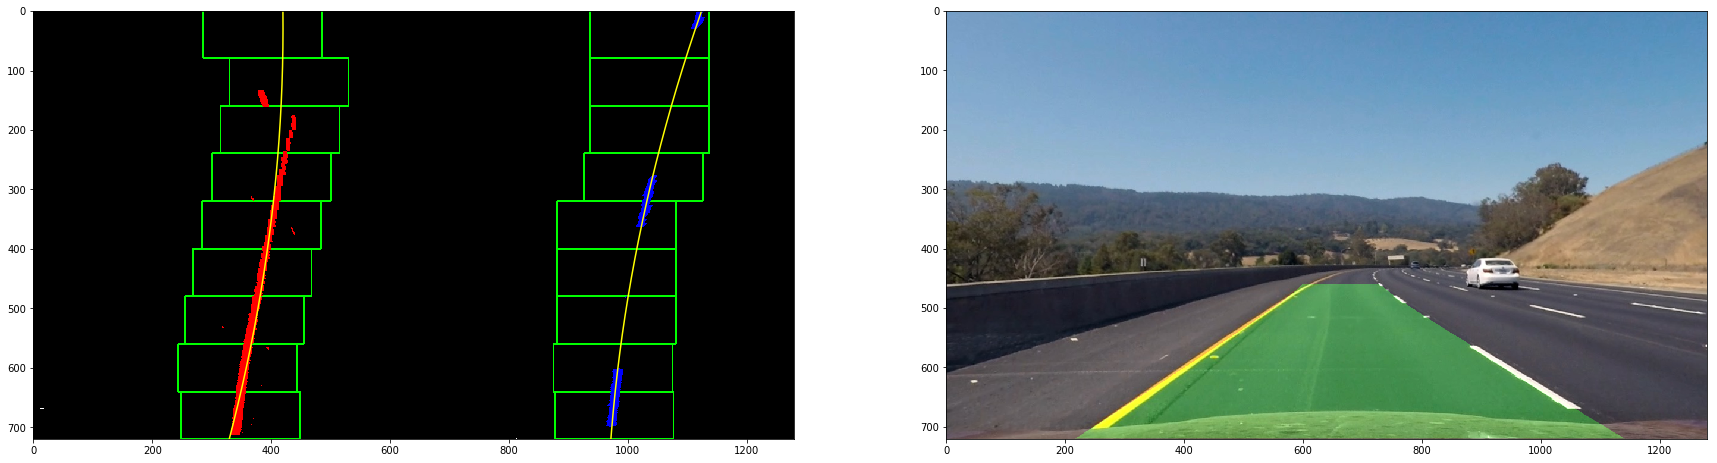

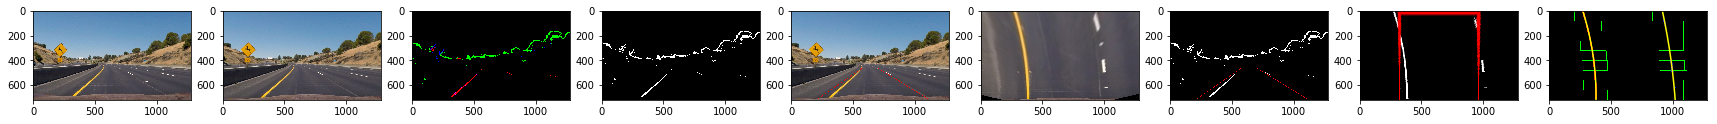

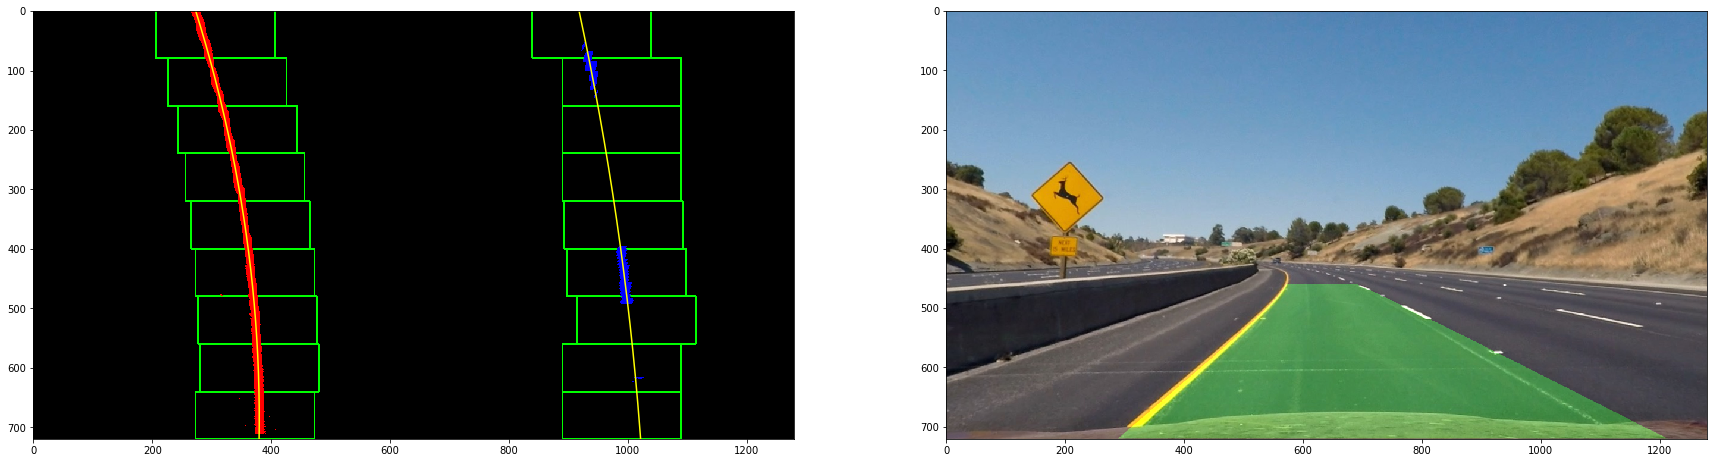

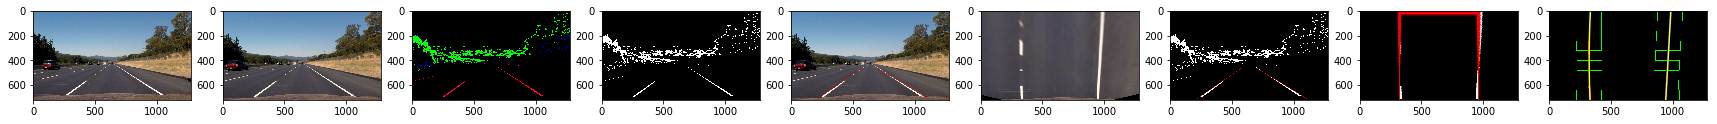

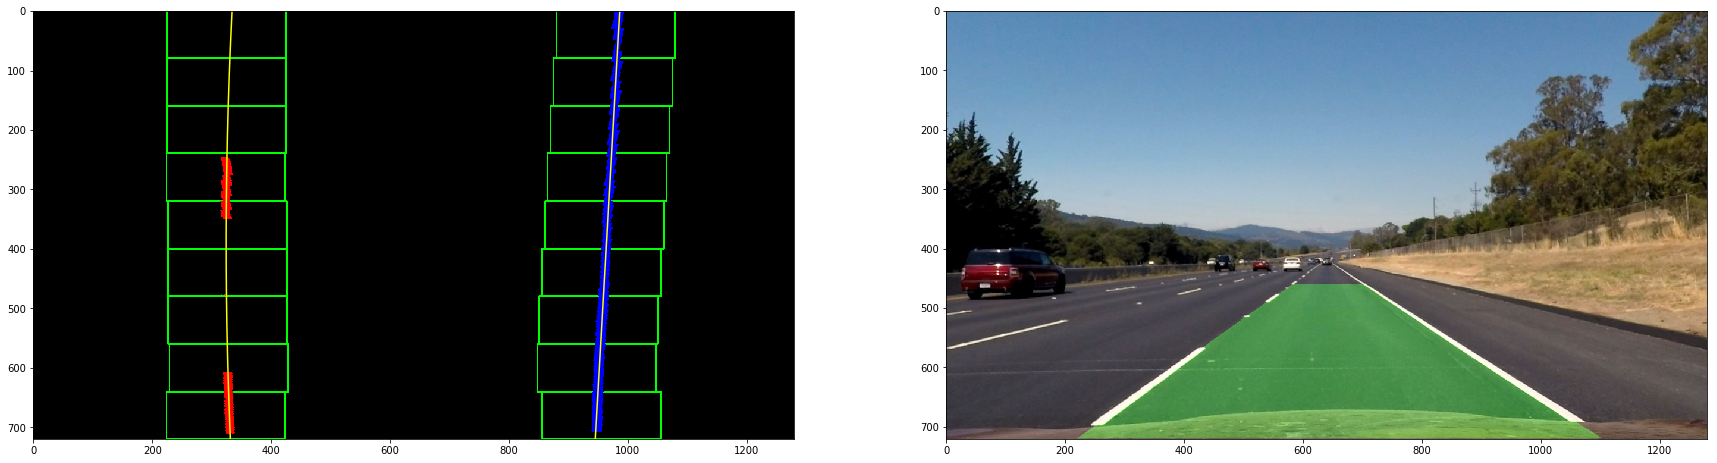

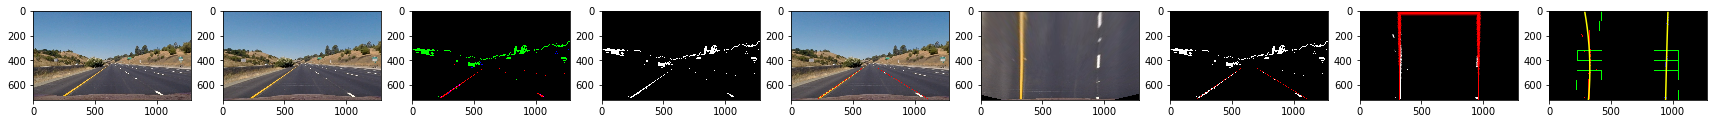

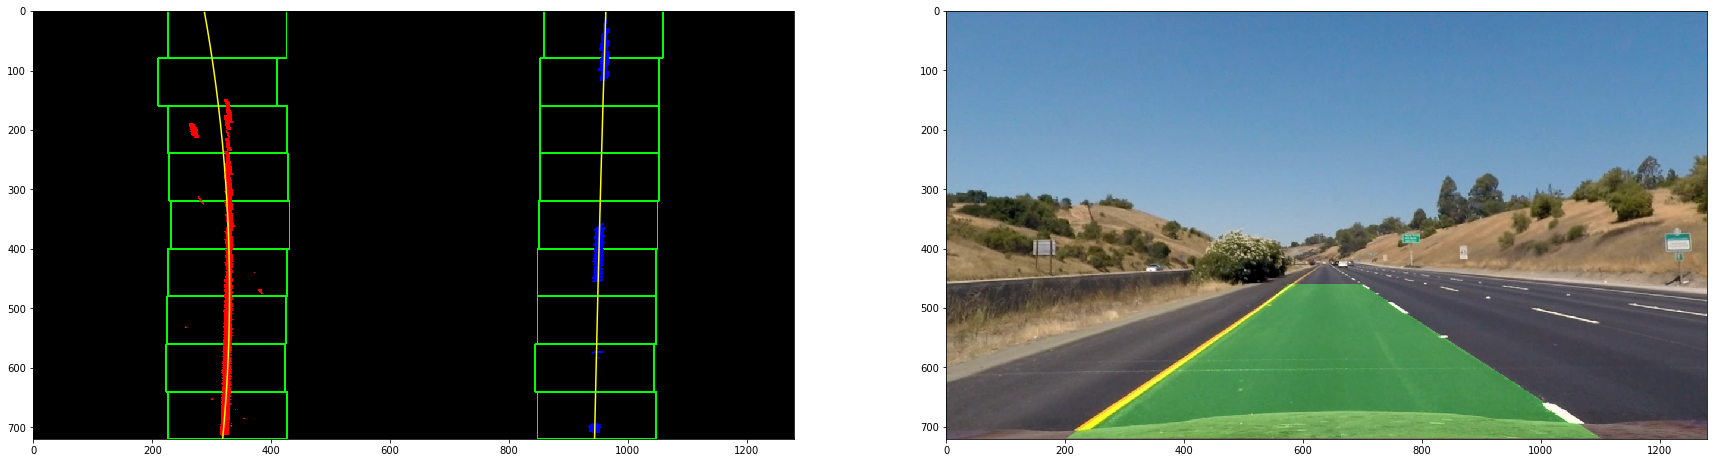

In [3]:
pylab.rcParams['figure.figsize'] = (30,30)


# Specify directory names.
in_dir = './test_images/'
out_dir = 'test_images_steps/'  # dir for intermediate images
#out_dir = 'test_images_out_detect/'

# Create output directories if needed.
if not os.path.exists(out_dir):
    os.makedirs(out_dir)


# Process each file in input directory.
for fn in os.listdir(in_dir):

    fname = fn.split('.')[0]
    ext = fn.split('.')[1]
    
    # Read in image
    im_dist = mpimg.imread(in_dir + fn)
    
    # Set up subplot keeping intermediate images
    f, axarr = plt.subplots(1, 9)
    axarr[0].imshow(im_dist)
    
    # Undistort image
    undist = cv2.undistort(im_dist, mtx, dist, None, mtx)
    axarr[1].imshow(undist)
    imsave(out_dir+fname+'+1.png', undist)
    
    
    # Obtain R channel 
    r_chan = undist[:, :, 0]
    r_thresh = (230, 255)
    r_binary = np.zeros_like(r_chan)
    r_binary[(r_chan > r_thresh[0]) & (r_chan <= r_thresh[1])] = 1
    
    
    # Convert to Grayscale, Obtain Sobel gradient in X direction, threshold
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    sobelx =cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*(abs_sobelx/np.max(abs_sobelx)))
    #sx_thresh = (20, 100)
    sx_thresh = (30, 110)
    sx_binary = np.zeros_like(scaled_sobelx)
    sx_binary[(scaled_sobelx  >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
        
    
    # Convert to HLS space, and use the S channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_chan = hls[:, :, 2]
    #s_thresh = (170, 255)    
    s_thresh = (190, 225)
    s_binary = np.zeros_like(s_chan)
    s_binary[(s_chan >= s_thresh[0]) & (s_chan <= s_thresh[1])] = 1
    
    h_chan = hls[:,:,0]
    h_thresh = (30, 100)
    h_binary = np.zeros_like(h_chan)
    h_binary[(h_chan > h_thresh[0]) & (h_chan <= h_thresh[1])] = 1
    
    # Stack channels
    #stack_bin = np.dstack((r_binary, sx_binary, s_binary)) * 255
    stack_bin = np.dstack((r_binary, h_binary, s_binary)) * 255

    # Combined threshold
    comb_binary = np.zeros_like(sx_binary)
    #comb_binary[(r_binary == 1) | (s_binary == 1) | (sx_binary == 1) | (h_binary == 1)] = 1
    comb_binary[(r_binary == 1) | (s_binary == 1) | (h_binary == 1)] = 1
    
    axarr[2].imshow(stack_bin)
    axarr[3].imshow(comb_binary, cmap='gray')
    
    imsave(out_dir+fname+'+2.png', stack_bin)
    imsave(out_dir+fname+'+3.png', comb_binary, cmap='gray')
    
    
    # Draw rectangular ROI for reference for src
    src = np.array([[(img_size[0] / 2) - 60, img_size[1] / 2 + 100], 
                            [((img_size[0] / 6) - 10), img_size[1] ],
                            [(img_size[0] * 5 / 6) + 60, img_size[1] ], 
                            [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]], np.int32)
    
    undist_ann = np.copy(undist)
    cv2.polylines(undist_ann,[src.reshape((-1,1,2))],True,(255,0,0),2)
    axarr[4].imshow(undist_ann)
    imsave(out_dir+fname+'+4.png', undist_ann)
    

    # Perspective transform for "birds-eye-view"
    binAsRGB = cv2.cvtColor(np.copy(comb_binary) * 255, cv2.COLOR_GRAY2RGB)
    cv2.polylines(binAsRGB,[src.reshape((-1,1,2))],True,(255,0,0),2)

    
    src = np.float32(
         [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
    dst = np.float32(
         [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
    
    # Obtain transform matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(np.copy(undist), M, img_size, flags=cv2.INTER_LINEAR)
    axarr[5].imshow(warped)
    imsave(out_dir+fname+'+5.png', warped)
    
    
    axarr[6].imshow(binAsRGB)
    binAsRGB_warped = cv2.warpPerspective(binAsRGB, M, img_size, flags=cv2.INTER_LINEAR)
    axarr[7].imshow(binAsRGB_warped)
    imsave(out_dir+fname+'+6.png', binAsRGB)
    imsave(out_dir+fname+'+7.png', binAsRGB_warped)

    
    
    binary_warped = cv2.warpPerspective(np.copy(comb_binary), M, img_size, flags=cv2.INTER_LINEAR)
    
    
    ### Sliding Window  - referred to "33. Finding the Lines" in the Project Material

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    imsave(out_dir+fname+'+8.png', out_img)
    
    savefig(out_dir+fname+'+coll.png')

    figure
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    savefig(out_dir+fname+'+9.png')
    

    # Final Image
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(out_img)
    axarr[0].plot(left_fitx, ploty, color='yellow')
    axarr[0].plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    ### Find Radius of Curvature - referred to "35. Measuring Curvature" section

    # Corresponds to bottom of image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polunomials to x, y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    # Finding vehicle offset from lane center
    # Referred to discussion post: https://discussions.udacity.com/t/where-is-the-vehicle-in-relation-to-the-center-of-the-road/237424
    camera_position = np.shape(im_dist)[1]/2
    lane_center = (rightx[719] + leftx[719])/2
    center_offset_pixels = abs(camera_position - lane_center)
    center_offset_meters = center_offset_pixels * xm_per_pix

    print("Radius of curvature: ", left_curverad, 'm, ', right_curverad, 'm', '    Center offset: ', center_offset_meters, 'm')
    
    
    ### Draw detected lane back onto image

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.array([pts], dtype=np.int32), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    axarr[1].imshow(result)
    imsave(out_dir+fname+'+out.png', result)

    

### Pipeline (video)

In [4]:
# Maintains a list of recent polynomial fit coefficients
class PrevWrap():
    def __init__(self):
        self.N = 25
        self.prev_l = []
        self.prev_r = []

# Pipeline for processing each frame of the video, 
# to be used with clip.fl_image
def process_img(im_dist):
    
    ## Parameters - placed here for convenience ##
    
    r_thresh = (185, 235)    # Red color thresholds
    sx_thresh = (30, 110)    # Sobel (x-direction) thresholds
    h_thresh = (30, 100)     # HLS H channel threshold
    s_thresh = (210, 255)   # HLS S channel threshold

    
    # global reference to prev_wrap, to maintain 
    # curvature fit information across frames
    global prev_wrap
    
    # Undistort image
    undist = cv2.undistort(im_dist, mtx, dist, None, mtx)
    
    # Obtain R channel 
    r_chan = undist[:, :, 0]
    r_binary = np.zeros_like(r_chan)
    r_binary[(r_chan > r_thresh[0]) & (r_chan <= r_thresh[1])] = 1
    
    # Convert to Grayscale, Obtain Sobel gradient in X direction, threshold
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    sobelx =cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*(abs_sobelx/np.max(abs_sobelx)))
    #sx_thresh = (20, 100)
    sx_binary = np.zeros_like(scaled_sobelx)
    sx_binary[(scaled_sobelx  >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
        
    # Convert to HLS space, and use the S channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_chan = hls[:, :, 2]
    #s_thresh = (170, 255)    
    s_binary = np.zeros_like(s_chan)
    s_binary[(s_chan >= s_thresh[0]) & (s_chan <= s_thresh[1])] = 1
    
    # Convert to HLS space, and use the H Channel
    h_chan = hls[:,:,0]
    h_binary = np.zeros_like(h_chan)
    h_binary[(h_chan > h_thresh[0]) & (h_chan <= h_thresh[1])] = 1
    
    # Combined threshold
    comb_binary = np.zeros_like(sx_binary)
    comb_binary[(r_binary == 1) | (s_binary == 1) | (sx_binary == 1) | (h_binary == 1)] = 1
    #comb_binary[(r_binary == 1) | (s_binary == 1) | (sx_binary == 1)] = 1
    
    
    # Draw rectangular ROI for reference for src
    src = np.array([[(img_size[0] / 2) - 60, img_size[1] / 2 + 100], 
                            [((img_size[0] / 6) - 10), img_size[1] ],
                            [(img_size[0] * 5 / 6) + 60, img_size[1] ], 
                            [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]], np.int32)
        
    src = np.float32(
         [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
    dst = np.float32(
         [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
    
    # Obtain transform matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    #warped = cv2.warpPerspective(np.copy(undist), M, img_size, flags=cv2.INTER_LINEAR)
    
    binary_warped = cv2.warpPerspective(np.copy(comb_binary), M, img_size, flags=cv2.INTER_LINEAR)
    
    # Reuse previous estimates if they exist
    if (len(prev_wrap.prev_l) > 0 and len(prev_wrap.prev_r) > 0):
                
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        
        left_fit = np.average(np.array(prev_wrap.prev_l), axis= 0).tolist();
        right_fit = np.average(np.array(prev_wrap.prev_r), axis= 0).tolist();
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    else: 
        ### Sliding Window  - referred to "33. Finding the Lines" in the Project Material

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    ### Find Radius of Curvature - referred to "35. Measuring Curvature" section

    # Corresponds to bottom of image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polunomials to x, y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Finding vehicle offset from lane center
    # Referred to discussion post: https://discussions.udacity.com/t/where-is-the-vehicle-in-relation-to-the-center-of-the-road/237424
    camera_position = np.shape(im_dist)[1]/2
    lane_center = (rightx[719] + leftx[719])/2
    center_offset_pixels = abs(camera_position - lane_center)
    center_offset_meters = center_offset_pixels * xm_per_pix

    
    # A few sanity checks
    sane = True
    # Update PrevWrap - if the new measurements seemed ok.
    if (sane):
        prev_wrap.prev_l.append(left_fit)
        prev_wrap.prev_r.append(right_fit)

        if len(prev_wrap.prev_l) > prev_wrap.N:
            prev_wrap.prev_l.pop(0)
        if len(prev_wrap.prev_r) > prev_wrap.N:
            prev_wrap.prev_r.pop(0)
       

    ### Draw detected lane back onto image

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.array([pts], dtype=np.int32), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Add annotations
    f_face = cv2.FONT_HERSHEY_PLAIN
    f_color = (22, 22, 22)
    f_scale = 1
    f_tn = 1
    cv2.putText(img=result,
        text='left radius = {}m'.format(left_curverad),
        org=(100, 100),
        fontFace=f_face,
        fontScale=f_scale,
        color=f_color,
        thickness=f_tn)
    cv2.putText(img=result,
        text='right radius = {}m'.format(right_curverad),
        org=(100, 120),
        fontFace=f_face,
        fontScale=f_scale,
        color=f_color,
        thickness=f_tn)
    cv2.putText(img=result,
        text='center offset = {}m'.format(center_offset_meters),
        org=(100, 140),
        fontFace=f_face,
        fontScale=f_scale,
        color=f_color,
        thickness=f_tn)
    
    return result
    

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_dir = './'
output_dir = './test_videos_output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
filename = 'project_video.mp4'

prev_wrap = PrevWrap()

# First bridge - lighter colorerd road, relatively straight
#clip1 = VideoFileClip(input_dir + filename).subclip(17,27)

# Second bridge - lighter colored road, curved, shadows
#clip1 = VideoFileClip(input_dir + filename).subclip(37,44)

# Full Clip
clip1 = VideoFileClip(input_dir + filename)
white_clip = clip1.fl_image(process_img) #
%time white_clip.write_videofile(output_dir + filename, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_dir + filename))

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [02:39<00:00,  8.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video.mp4 

CPU times: user 3min 37s, sys: 31.3 s, total: 4min 8s
Wall time: 2min 39s
